# Loading Model 

In [1]:
import os
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, Lambda
from tensorflow.keras.models import load_model


2021-11-29 17:15:03.951324: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-29 17:15:03.951781: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
con_win_size = 9
num_strings = 6
num_classes = 21
input_shape = (192, con_win_size, 1)

def softmax_by_string(t):
    sh = K.shape(t)
    string_sm = []
    for i in range(num_strings):
        string_sm.append(K.expand_dims(K.softmax(t[:, i, :]), axis=1))
    return K.concatenate(string_sm, axis=1)

def build_model():

    model = Sequential()
    model.add(
        Conv2D(32,
               kernel_size=(3, 3),
               activation="relu",
               input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes * num_strings))  # no activation
    model.add(Reshape((num_strings, num_classes)))
    model.add(Activation(softmax_by_string))

#     model.compile(loss=self.catcross_by_string,
#                   optimizer=Adadelta(),
#                   metrics=[self.avg_acc])

    return model
model = build_model()

2021-11-29 17:15:08.616355: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-29 17:15:08.616423: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-29 17:15:08.616514: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-GP5BU3LN): /proc/driver/nvidia/version does not exist
2021-11-29 17:15:08.617008: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 190, 7, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 188, 5, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 186, 3, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 93, 1, 64)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 93, 1, 64)         0         
                                                                 
 flatten (Flatten)           (None, 5952)              0         
                                                        

# Load model weights 

In [4]:
os.chdir('../h5-model')
!ls

full_val0_75acc_weights.h5


In [5]:
model.load_weights('full_val0_75acc_weights.h5')

In [6]:
model

In [7]:
weights = []
for layer in model.layers:
    weights.append(layer.get_weights())
print(weights)
print(len(weights[0]))

[[array([[[[-1.14527084e-01, -7.00837746e-02,  1.64513141e-02,
          -8.46667960e-02,  7.80746713e-02, -6.10514767e-02,
           1.10172659e-01, -1.30868405e-01,  1.17944069e-01,
           8.05187821e-02,  1.33489624e-01, -6.60827989e-03,
          -7.73175359e-02,  3.72690037e-02,  1.03387728e-01,
           8.85068849e-02, -5.47240674e-02, -9.36797783e-02,
           2.81246901e-02,  3.64853963e-02,  1.42038763e-01,
          -3.35541889e-02, -2.07621288e-02,  3.52249779e-02,
          -1.24825507e-01, -1.00334905e-01,  6.65799752e-02,
          -1.16388358e-01, -3.19974236e-02, -1.70573920e-01,
          -7.60619119e-02,  1.46001697e-01]],

        [[-4.05685678e-02,  1.66681096e-01,  1.29631609e-01,
          -2.65946500e-02,  5.08399941e-02, -1.38498351e-01,
          -6.97663724e-02, -1.22033164e-01,  1.14255841e-03,
           1.18322901e-01, -1.16930827e-01,  1.51325539e-01,
          -5.27841933e-02,  6.96947202e-02, -1.35874555e-01,
           1.45532504e-01,  1.409107

# preprocess experimentmono.wav 


In [1]:
import os
import numpy as np
import jams
from scipy.io import wavfile
import sys
import librosa
from tensorflow.keras.utils import to_categorical


class TabDataReprGen:
    def __init__(self, mode="c"):
        # file path to the GuitarSet dataset
        path = "data/GuitarSet/"
        self.path_audio = path + "audio/audio_mic/"
        self.path_anno = path + "annotation/"

        # labeling parameters
        self.string_midi_pitches = [40, 45, 50, 55, 59, 64]
        self.highest_fret = 19
        self.num_classes = self.highest_fret + 2  # for open/closed

        # prepresentation and its labels storage
        self.output = {}

        # preprocessing modes
        #
        # c = cqt
        # m = melspec
        # cm = cqt + melspec
        # s = stft
        #
        self.preproc_mode = mode    # Preprocessing mode for the wav file data
        self.downsample = True      # Select to lower sample rate of data
        self.normalize = True       # Select to normalize data
        self.sr_downs = 22050       # Lowered sample rate

        # CQT parameters
        self.cqt_n_bins = 192           # Number of bins for the constant-Q transform "c"
        self.cqt_bins_per_octave = 24   # Number of bins per octave

        # STFT parameters
        self.n_fft = 2048       # Length of the FFT window
        self.hop_length = 512   # Number of samples between successive frames

        # save file path
        self.save_path = "data/spec_repr/" + self.preproc_mode + "/"

    def load_rep_and_labels_from_raw_file(self, filename):
        """
        Loads wav and jams files, reads wav file and creates sample rate [int]
        and data [np.array].
        Constructs, cleans, and categorizes labels and stores them in output dict
        Returns the number of frames
        """
        file_audio = filename
        #file_audio = self.path_audio + filename + "_mic.wav"    # wav file
        #file_anno = self.path_anno + filename + ".jams"         # jams file
        #jam = jams.load(file_anno)                              # loads jams file
        self.sr_original, data = wavfile.read(file_audio)       # creates sample rate [int] and data from wav file
        self.sr_curr = self.sr_original

        # preprocess audio, store in output dict
        self.output["repr"] = np.swapaxes(self.preprocess_audio(data), 0, 1)

        # construct labels
        frame_indices = range(len(self.output["repr"]))  # Counts the frames
        times = librosa.frames_to_time( # Converts frame counts to time (seconds)
            frame_indices,
            sr=self.sr_curr,            # Sample rate
            hop_length=self.hop_length  # Number of samples between successive frames
            )
        return data


    
    
    def correct_numbering(self, n):
        """
        Adds +1 to correct the string number
        """
        n += 1
        if n < 0 or n > self.highest_fret:
            n = 0
        return n

    def categorical(self, label):
        """
        Categorizes the label in the number of classes defined
        (highest_fret (19) + 2  # for open/closed)
        """
        return to_categorical(label, self.num_classes)

    def clean_label(self, label):
        """
        Takes the label, corrects the string numbering and categorizes the label
        using to_categorical.
        Returns categorized and clean label
        """
        label = [self.correct_numbering(n) for n in label]
        return self.categorical(label)

    def clean_labels(self, labels):
        """
        Returns an array of all the cleaned labels with the correct string numbering
        and categorized according to the number of classes defined
        """
        return np.array([self.clean_label(label) for label in labels])

    def preprocess_audio(self, data):
        """
        Preprocesses data depending on mode selected using librosa.
        It converts data to float, then it normalizes it and resamples it
        to a lower sample rate. Then, preprocesses it and returns the processed data
            Args:
                data ([np.array]): [data created by wavfile.read]
            Returns:
                [np.ndarrray[shape=(n_bins, t)]]: [preprocessed data array]
        """
        data = data.astype(float)
        if self.normalize:
            data = librosa.util.normalize(data)
        if self.downsample:
            data = librosa.resample(data, self.sr_original, self.sr_downs)
            self.sr_curr = self.sr_downs
        if self.preproc_mode == "c":
            data = np.abs(
                librosa.cqt(data,     # Computes the constant-Q transform of an audio signal
                            hop_length=self.hop_length,
                            sr=self.sr_curr,        # data sample rate
                            n_bins=self.cqt_n_bins,
                            bins_per_octave=self.cqt_bins_per_octave))
        else:
            print("invalid representation mode.")

        return data

    def save_data(self, filename):
        """
        Saves the generated data output dictionary into an npz file
        """
        np.savez(filename, **self.output)

    def get_nth_filename(self, n):
        """
        Sorts the jams files in the directory, looks for the nth one,
        removes the .jams extension and returns only the filename
            Returns:
                [str]: [filename]
        """
        filenames = np.sort(np.array(os.listdir(self.path_anno)))
        filenames = list(filter(lambda x: x[-5:] == ".jams", filenames))
        print(filenames[n])
        return filenames[n][:-5]

    def load_and_save_repr_nth_file(self, n):
        """
        Gets the filename, preprocesses it, and gets the number of frames.
        Saves the file as an npz
        """

        filename = self.get_nth_filename(n)     # Gets only filename with no .jams extension
        print(filename)
        num_frames = self.load_rep_and_labels_from_raw_file(filename)
        print("done: " + filename + ", " + str(num_frames) + " frames")
        save_path = self.save_path
        if not os.path.exists(save_path):               # Creates saving path if it does not exist
            os.makedirs(save_path)
        self.save_data(save_path + filename + ".npz")   # Saves generated output dictionary in an npz file

2021-11-29 17:28:11.820069: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-29 17:28:11.820131: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import pandas as pd
import numpy as np
filenames = '../raw_data/experimentmono.wav'
genrep = TabDataReprGen()
data = genrep.load_rep_and_labels_from_raw_file(filenames)
process = np.swapaxes(genrep.preprocess_audio(data),0,1)

process.shape

/tmp/ipykernel_24765/1941861401.py:59: WavFileWarning: Chunk (non-data) not understood, skipping it.
  self.sr_original, data = wavfile.read(file_audio)       # creates sample rate [int] and data from wav file


(711, 192)

In [3]:
halfwin = con_win_size // 2

NameError: name 'con_win_size' is not defined

In [ ]:
len(process)

711

In [ ]:
full_x = np.pad(process, [(halfwin, halfwin), # full x is the entire song padded with halfwin*2 frames
                                             (0, 0)],mode='constant')
full_x.shape

(719, 192)

In [ ]:
full_x.shape[0]

719

In [ ]:
# x_new = [np.empty((full_x.shape[0],192,9,1))]
# for frame_idx in range(0,full_x.shape[0]): # for all frames in the experiment
#     sample_x = full_x[frame_idx:frame_idx + con_win_size]
#     np.append(x_new,np.expand_dims(np.swapaxes(sample_x, 0, 1), -1))


In [ ]:
x_new = []
for frame_idx in range(0, len(process)):  # for all frames in the experiment
    sample_x = full_x[frame_idx:frame_idx + con_win_size]
    print(sample_x.shape)
    x_new.append(np.expand_dims(np.swapaxes(sample_x, 0, 1), -1))


(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(9, 192)
(

In [ ]:
len(x_new)

711

In [ ]:
len(x_new[0])

192

In [ ]:
len(x_new[0][0])

9

In [ ]:
len(x_new[0][0][0])

1

In [ ]:
import tensorflow as tf
x_new = np.array(x_new,dtype='float32')

In [49]:
y_pred = model.predict(x_new)

In [50]:
y_pred.shape

(711, 6, 21)

In [51]:
y_pred[0].shape


(6, 21)

In [52]:
frame0 = pd.DataFrame(y_pred[0])

In [53]:
frame0

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.992332,0.001184,0.000413,0.001276,0.001992,0.000882,0.000504,0.000554,0.000365,0.000124,...,0.000027,0.000057,0.000030,0.000022,0.000017,0.000020,0.000032,0.000029,0.000025,0.000038
1,0.986489,0.000596,0.000818,0.001061,0.001781,0.002152,0.001505,0.003192,0.000930,0.000455,...,0.000240,0.000104,0.000058,0.000032,0.000046,0.000014,0.000013,0.000021,0.000016,0.000009
2,0.970600,0.000931,0.000368,0.001192,0.002640,0.001802,0.002249,0.007422,0.001678,0.007115,...,0.001729,0.000579,0.000168,0.000166,0.000060,0.000037,0.000024,0.000018,0.000052,0.000030
3,0.957632,0.001125,0.001582,0.002689,0.001604,0.003615,0.002887,0.009451,0.005479,0.003247,...,0.002939,0.001327,0.000681,0.000609,0.000070,0.000095,0.000032,0.000098,0.000049,0.000054
4,0.955649,0.001492,0.001675,0.002751,0.001442,0.003308,0.004358,0.008719,0.003175,0.006137,...,0.002641,0.001473,0.001082,0.000995,0.000118,0.000308,0.000149,0.000068,0.000037,0.000052
5,0.981440,0.001557,0.000635,0.001736,0.001719,0.001362,0.000972,0.002494,0.001598,0.001896,...,0.001693,0.000603,0.000692,0.000491,0.000079,0.000018,0.000083,0.000036,0.000026,0.000034


In [54]:
frame0[0][5] = 0.3

In [56]:
frame0[0]

0    0.992332
1    0.986489
2    0.970600
3    0.957632
4    0.955649
5    0.300000
Name: 0, dtype: float32

In [57]:
frame0[0][frame0[0] < 0.9]


5    0.3
Name: 0, dtype: float32

In [58]:
frame0[0].replace(to_replace=list(frame0[0][frame0[0] < 0.9]), value=0, inplace=True)


In [59]:
frame0[0]

0    0.992332
1    0.986489
2    0.970600
3    0.957632
4    0.955649
5    0.000000
Name: 0, dtype: float64

In [149]:
frame0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       6 non-null      float32
 1   1       6 non-null      float32
 2   2       6 non-null      float32
 3   3       6 non-null      float32
 4   4       6 non-null      float32
 5   5       6 non-null      float32
 6   6       6 non-null      float32
 7   7       6 non-null      float32
 8   8       6 non-null      float32
 9   9       6 non-null      float32
 10  10      6 non-null      float32
 11  11      6 non-null      float32
 12  12      6 non-null      float32
 13  13      6 non-null      float32
 14  14      6 non-null      float32
 15  15      6 non-null      float32
 16  16      6 non-null      float32
 17  17      6 non-null      float32
 18  18      6 non-null      float32
 19  19      6 non-null      float32
 20  20      6 non-null      float32
dtypes: float32(21)
memory usage: 632.0 bytes


In [150]:
frame0.drop(columns=[0])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.001216,0.000740,0.001494,0.010979,0.000649,0.001142,0.001141,0.000811,0.000091,0.000076,0.000111,0.000276,0.000121,0.000114,0.000037,0.000226,0.000199,0.000069,0.000099,0.000167
1,0.000192,0.000566,0.005362,0.002697,0.000652,0.004411,0.002306,0.000292,0.000069,0.000156,0.000336,0.000343,0.000150,0.000169,0.000148,0.000003,0.000072,0.000205,0.000106,0.000044
2,0.045170,0.002923,0.007622,0.004365,0.007041,0.200291,0.019890,0.002199,0.013776,0.006176,0.004411,0.002528,0.003746,0.003479,0.000381,0.000554,0.003630,0.000704,0.001995,0.000487
3,0.063900,0.024889,0.016828,0.011251,0.006439,0.047923,0.032714,0.087999,0.059447,0.022549,0.018730,0.034555,0.041511,0.008734,0.001058,0.002761,0.000464,0.002337,0.006234,0.000455
4,0.015246,0.022375,0.020392,0.079250,0.011555,0.022684,0.026017,0.025484,0.470929,0.023794,0.009667,0.029389,0.022959,0.002919,0.004729,0.007976,0.002942,0.000647,0.000963,0.004982
5,0.023355,0.004948,0.027743,0.095466,0.059997,0.017026,0.083880,0.077653,0.019808,0.009983,0.053209,0.018466,0.015056,0.006965,0.006819,0.002780,0.000738,0.000319,0.000951,0.017160


In [151]:
frame0.idxmax(axis='columns')

0    0
1    0
2    0
3    0
4    9
5    0
dtype: int64

In [152]:
frame0 = frame0.drop(columns=[0])
frame0

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.001216,0.000740,0.001494,0.010979,0.000649,0.001142,0.001141,0.000811,0.000091,0.000076,0.000111,0.000276,0.000121,0.000114,0.000037,0.000226,0.000199,0.000069,0.000099,0.000167
1,0.000192,0.000566,0.005362,0.002697,0.000652,0.004411,0.002306,0.000292,0.000069,0.000156,0.000336,0.000343,0.000150,0.000169,0.000148,0.000003,0.000072,0.000205,0.000106,0.000044
2,0.045170,0.002923,0.007622,0.004365,0.007041,0.200291,0.019890,0.002199,0.013776,0.006176,0.004411,0.002528,0.003746,0.003479,0.000381,0.000554,0.003630,0.000704,0.001995,0.000487
3,0.063900,0.024889,0.016828,0.011251,0.006439,0.047923,0.032714,0.087999,0.059447,0.022549,0.018730,0.034555,0.041511,0.008734,0.001058,0.002761,0.000464,0.002337,0.006234,0.000455
4,0.015246,0.022375,0.020392,0.079250,0.011555,0.022684,0.026017,0.025484,0.470929,0.023794,0.009667,0.029389,0.022959,0.002919,0.004729,0.007976,0.002942,0.000647,0.000963,0.004982
5,0.023355,0.004948,0.027743,0.095466,0.059997,0.017026,0.083880,0.077653,0.019808,0.009983,0.053209,0.018466,0.015056,0.006965,0.006819,0.002780,0.000738,0.000319,0.000951,0.017160


In [153]:
list(frame0.idxmax(axis='columns'))

[4, 3, 6, 8, 9, 4]

In [143]:
def full_tab(y_pred):
    tab_dict = {
        'E': [],
        'A': [],
        'D': [],
        'G': [],
        'B': [],
        'e': [],
    }
    tablature = pd.DataFrame.from_dict(tab_dict)
    tablature = tablature.T
    for frame_idx in range(0,len(y_pred)):
        this_frame = pd.DataFrame(y_pred[frame_idx])
        this_frame = this_frame.drop(columns=[0])
        tablature[str(frame_idx)] = list(frame0.idxmax(axis='columns'))
    return tablature

In [144]:
my_tab = full_tab(y_pred)
my_tab

/tmp/ipykernel_11688/847786349.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  tablature[str(frame_idx)] = list(frame0.idxmax(axis='columns'))


,0,1,2,3,4,5,6,7,8,9,...,701,702,703,704,705,706,707,708,709,710
E,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [137]:
my_tab['360']

E    0
A    0
D    0
G    0
B    0
e    0
Name: 360, dtype: int64

In [57]:
import pandas as pd
tab_dict={'E':[],
          'A':[],
          'D':[],
          'G':[],
          'B':[],
          'e':[],
          }
tablature = pd.DataFrame.from_dict(tab_dict)
tablature = tablature.T
tablature


""
E
A
D
G
B
e


In [58]:
len(y_pred)

719

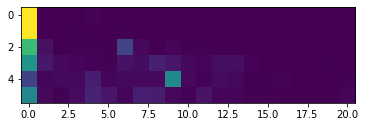

In [127]:
import matplotlib.pyplot as plt
plt.imshow(y_pred[:, :][360])


In [65]:
this_frame = pd.DataFrame(y_pred[150])
this_frame

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.992294,0.001195,0.000415,0.001278,0.002004,0.000884,0.000505,0.000557,0.000367,0.000125,...,0.000027,0.000057,0.000030,0.000022,0.000017,0.000020,0.000032,0.000029,0.000026,0.000038
1,0.986600,0.000593,0.000814,0.001053,0.001766,0.002129,0.001480,0.003172,0.000926,0.000452,...,0.000238,0.000103,0.000058,0.000032,0.000046,0.000013,0.000013,0.000021,0.000016,0.000009
2,0.970662,0.000918,0.000366,0.001193,0.002636,0.001788,0.002237,0.007382,0.001675,0.007143,...,0.001730,0.000576,0.000167,0.000166,0.000059,0.000037,0.000024,0.000018,0.000052,0.000030
3,0.957465,0.001125,0.001582,0.002689,0.001605,0.003633,0.002892,0.009490,0.005513,0.003275,...,0.002956,0.001334,0.000685,0.000612,0.000070,0.000096,0.000032,0.000098,0.000049,0.000054
4,0.955603,0.001501,0.001680,0.002755,0.001441,0.003293,0.004368,0.008746,0.003153,0.006144,...,0.002650,0.001481,0.001079,0.001001,0.000117,0.000308,0.000149,0.000069,0.000037,0.000052
5,0.981500,0.001551,0.000632,0.001727,0.001702,0.001364,0.000966,0.002485,0.001595,0.001890,...,0.001696,0.000601,0.000693,0.000489,0.000079,0.000018,0.000082,0.000036,0.000026,0.000034


In [66]:

this_frame.idxmax(axis='columns')

0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64

In [51]:
for frame_idx in range(0,len(y_pred)):
    this_frame = pd.DataFrame(y_pred[frame_idx])
    tablature[str(frame_idx)] = this_frame.idxmax(axis='columns')[0]


/tmp/ipykernel_11688/173296956.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  tablature[str(frame_idx)] = this_frame.idxmax(axis='columns')[0]


In [52]:
tablature

,0,1,2,3,4,5,6,7,8,9,...,709,710,711,712,713,714,715,716,717,718
E,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


NameError: name 'getStringFret' is not defined

In [ ]:
import matplotlib.pyplot as plt


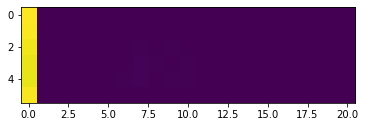

In [ ]:
for frame in range(0,719):
    plt.imshow(y_pred[frame])